<h1> HOW TO: </h1>

1. Edit the configs list in Cell 3 (CONFIG DEFINITIONS) with all experiments you want to try
2. Run Cell 2 (RESULT STORAGE) to initialize results storage
3. Run Cell 4 (TRAINING FUNCTION) to define the training function
4. Run Cell 5 (MAIN EXECUTION LOOP) to start training 
5. When done, run Cells 6-8 to analyze and save results

<h2> Imports

In [1]:
import sys
sys.path.append("../src")
from precomputed_dataset import precomputedDataset
from modules import MPNNLayer, MPNNTokenizer, SelfAttentionEncoder, PredictionHead
from model import MPNNTransformerModel

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader as PyGDataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from datetime import datetime
import time
import json

<h2> Result Storage & Utility </h2>

In [2]:
# --- Results for all configurations ---
all_results = []
all_model_states = []

# --- Utility function to check gradient flow ---
def check_gradients(model):
    """Check if gradients are flowing properly"""
    total_norm = 0.0
    param_count = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
            param_count += 1
    total_norm = total_norm ** 0.5
    return total_norm, param_count

# ---- Utility function to evaluate model on a dataset ---
def evaluate(model, dataset, device, lambda_str):
    """Evaluate model on a dataset and return average loss, predictions, and targets"""
    model.eval()
    total_loss = 0.0
    # --- Multi Task losses and predictions ---
    total_loss_loc = 0.0
    total_loss_str = 0.0
    loc_predictions = []
    loc_targets = []
    str_predictions = []
    str_targets = []
    
    with torch.no_grad():
        for data in dataset:
            # --- predictions --- #
            data = data.to(device)
            pred_loc, pred_str = model.forward_from_data(data)
            target_loc = data.y.squeeze(0)  # Removing the batching dimension, because evaluation is done on a single graph
            target_str = data.strength.squeeze(0)  # Removing the batching dimension

            # --- losses --- #
            loss_loc = F.mse_loss(pred_loc, target_loc).item()
            loss_str = F.mse_loss(pred_str, target_str).item()
            total_loss_loc += loss_loc
            total_loss_str += loss_str
            total_loss += loss_loc + lambda_str * loss_str
            
            loc_predictions.append(pred_loc.cpu().numpy().squeeze())
            loc_targets.append(target_loc.cpu().numpy().squeeze())
            str_predictions.append(pred_str.cpu().numpy().squeeze())
            str_targets.append(target_str.cpu().numpy().squeeze())
    
    avg_loss_loc = total_loss_loc / len(dataset)
    avg_loss_str = total_loss_str / len(dataset)
    avg_total_loss = total_loss / len(dataset)
    return avg_total_loss, avg_loss_loc, avg_loss_str, np.array(loc_predictions), np.array(loc_targets), np.array(str_predictions), np.array(str_targets)

# --- Utility function to visualize predictions vs targets ---
def visualize_predictions(predictions, targets):
    plt.figure(figsize=(8, 8))
    plt.scatter(targets[:50, 0], targets[:50, 1], c='green', marker='o', 
                s=100, alpha=0.6, label='Target', edgecolors='black')
    plt.scatter(predictions[:50, 0], predictions[:50, 1], c='red', marker='x', 
                s=100, alpha=0.6, label='Prediction')
    
    # Draw lines connecting predictions to targets
    for i in range(50):
        plt.plot([predictions[i, 0], targets[i, 0]], 
                [predictions[i, 1], targets[i, 1]], 
                'k--', alpha=0.3, linewidth=0.5)
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title(f'Predictions vs Targets')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

<h2> Config definitions

In [5]:
# --- define each configuration as a dictionary ---
configs = [ 
    {
        'name': 'multitask_test', 
        'num_epochs': 25,
        # --- Architecture ---
        #MPNN Tokenizer
        'mpnn_hidden_dim': 128,
        'mpnn_num_layers': 3, 
        'mp_layer_norm': False,
        'token_dim': 128,
        #Self-Attention Encoder
        'attn_num_heads': 4, #embed_dim must be divisible by num_heads, so if we stay at 128 token dim, 2n
        'attn_num_layers': 4, 
        'pooling_strategy': 'cls_token',
        #Prediction Head
        'head_mlp_hidden_dim': 256,
        #Regularization
        'mpnn_dropout': 0.1,
        'attn_dropout': 0.1,
        'head_dropout': 0.1,
        # --- Hyperparameters ---
        'lr': 5e-4,
        'weight_decay': 0.0,
        'batch_size': 128,
        # --- Scheduler params --- 
        'scheduler': True,
        'mode': 'min',
        'factor': 0.8,
        'patience': 20,
        'threshold': 1e-5, 
        'threshold_mode': "rel",
        'cooldown': 5,
        'min_lr': 1e-6,
        # --- Multi-task loss weight ---
        'lambda_str': 0.3,
    },
]

<h2> Training Function

In [6]:
def train_single_config(config, device, train_path, val_path, test_path, seed=0):
    """
    Train a model with given configuration and return results and corresponding best models

    """
    
    # Set seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"\n{'='*60}")
    print(f"TRAINING CONFIG: {config['name']}")
    print(f"{'='*60}\n")
    
    # --- Load Datasets ---
    train_ds = precomputedDataset(train_path)
    val_ds = precomputedDataset(val_path)
    test_ds = precomputedDataset(test_path) 

    train_loader = PyGDataLoader(
        train_ds, 
        batch_size=config['batch_size'], 
        shuffle=True,  
        num_workers=4, 
        pin_memory=True if torch.cuda.is_available() else False
    )

    # --- Initialize model ---
    sample0 = train_ds[0]
    
    model = MPNNTransformerModel(
        node_in_dim=sample0.x.shape[-1],
        edge_in_dim=sample0.edge_attr.shape[-1],
        num_output_sources=1,
        mpnn_hidden_dim=config['mpnn_hidden_dim'],
        mpnn_num_layers=config['mpnn_num_layers'],
        mp_layer_norm=config['mp_layer_norm'],
        token_dim=config['token_dim'],
        attn_num_heads=config['attn_num_heads'],
        attn_num_layers=config['attn_num_layers'],
        head_mlp_hidden_dim=config['head_mlp_hidden_dim'],
        mpnn_dropout=config['mpnn_dropout'],
        attn_dropout=config['attn_dropout'],
        head_dropout=config['head_dropout'],
        pooling_strategy=config['pooling_strategy']
    ).to(device)
    
    # --- Optimizer and Scheduler ---
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.999),
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode=config['mode'],
        factor=config['factor'],          
        patience=config['patience'],       
        threshold=config['threshold'],    
        threshold_mode=config['threshold_mode'],
        cooldown=config['cooldown'],        
        min_lr=config['min_lr'],
    )

    # --- Multi-task loss weight ---
    lambda_str = config['lambda_str']
    
    # --- Training tracking ---
    train_loss_history = []
    loc_loss_history = []
    str_loss_history = []
    val_loss_history = []
    pred_std_history = []
    grad_norm_history = []

    # --- Early Stopping ---
    best_val_loss = float('inf')
    best_train_loss = float('inf') #Train loss that corresponds to best validation loss
    patience_counter = 0
    patience = 50 # Set here 
    min_delta = 1e-5 # Set here

    # --- For saving the best model ---
    best_model_state = None 

    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    # --- Training loop ---
    for epoch in range(1, config['num_epochs'] + 1):
        model.train()
        epoch_loss = 0.0
        epoch_loss_loc = 0.0
        epoch_loss_str = 0.0
        epoch_preds_loc = []
        epoch_preds_str = []
        
        for data in train_loader:
            # --- prediction --- # 
            data = data.to(device)
            pred_loc, pred_str = model.forward_from_data(data)  
            
            # --- multi-task loss --- #
            loss_loc = F.mse_loss(pred_loc, data.y)
            loss_str = F.mse_loss(pred_str, data.strength)
            loss = loss_loc + lambda_str * loss_str
            
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_loss_loc += loss_loc.item()
            epoch_loss_str += loss_str.item()
            epoch_preds_loc.append(pred_loc.detach().cpu().numpy())
            epoch_preds_str.append(pred_str.detach().cpu().numpy())
        
        # --- compute metrics at epoch level ---
        train_loss = epoch_loss / len(train_loader)
        train_loss_history.append(train_loss)
        avg_loss_loc = epoch_loss_loc / len(train_loader)
        avg_loss_str = epoch_loss_str / len(train_loader)
        loc_loss_history.append(avg_loss_loc)
        str_loss_history.append(avg_loss_str)

        # --- std of loc predictions --- #
        pred_std = np.concatenate(epoch_preds_loc, axis=0).std(axis=0).mean()
        pred_std_history.append(pred_std)

        grad_norm, _ = check_gradients(model) #Important for dialing in clipping
        grad_norm_history.append(grad_norm)

        # --- Validation ---
        val_loss, val_loss_loc, val_loss_str, _, _, _, _ = evaluate(model, val_ds, device, lambda_str)
        val_loss_history.append(val_loss)

        # --- Update best metrics ---
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_train_loss = train_loss
            patience_counter = 0
            if epoch > 100:
                best_model_state = model.state_dict()
        else:
            patience_counter += 1

        # --- Update Scheduler  ---
        if config['scheduler'] == True:
            scheduler.step(val_loss)

        # --- Logging ---
        if epoch == 1 or epoch % 1 == 0:
            print(f"Epoch {epoch:4d} | Train Loss: {train_loss:.6f} | "
      f"Loc: {avg_loss_loc:.6f} | Str: {avg_loss_str:.6f} | "
      f"Val Loss: {val_loss:.6f} | Best Val: {best_val_loss:.6f} | "
      f"Patience: {patience_counter}/{patience} | "
      f"LR: {optimizer.param_groups[0]['lr']:.2e} | Pred_std: {pred_std:.4f}")

                 #Grad_norm: {grad_norm:.4f} |

        # --- Check for stopping conditions
        if pred_std < 0.004:
            print(f"  WARNING: Predictions collapsed at epoch {epoch}!")
            break
        
        if train_loss < 5e-5:
            print(f"  Converged at epoch {epoch}")
            break     

        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch} (val_loss={val_loss:.6f})")
            break   

    # --- saving final train loss
    final_train_loss = train_loss_history[-1]
   
    # --- Evaluation ---
    print(f"\nEvaluating on test set...")
    
    # --- Load best model if available ---
    if best_model_state is not None:
        print(f"Loading best model from epoch > 100...")
        model.load_state_dict(best_model_state)
    else:
        print(f"No best model saved (epoch <= 100), using final model...")

    test_loss, test_loss_loc, test_loss_str, loc_preds, loc_tgts, str_preds, str_tgts = evaluate(model, test_ds, device, lambda_str)
    
    print(f"Train Loss: {best_train_loss:.6f}")
    print(f"Combined Test loss: {test_loss:.6f}")
    print(f"Test loss (loc): {test_loss_loc:.6f}")
    print(f"Test loss (str): {test_loss_str:.6f}")
    print(f"Generalization gap: {np.abs(test_loss - best_train_loss):.6f}")
    
    # --- Prepare results ---
    results = {
        'config_name': config['name'],
        
        # --- Final metrics (at stopping point) ---
        'final_train_loss': final_train_loss,
     
        'test_loss': test_loss,
        'test_loss_loc': test_loss_loc,
        'test_loss_str': test_loss_str,
        'best_train_loss' : best_train_loss,
        'generalization_gap': abs(test_loss - best_train_loss),
          
        # --- Predictions and training history ---
        'loc_predictions': loc_preds,
        'loc_targets': loc_tgts,
        'str_predictions': str_preds,
        'str_targets': str_tgts,
        'epochs_trained': len(train_loss_history),
        'train_loss_history': train_loss_history,
        'loc_loss_history': loc_loss_history,
        'str_loss_history': str_loss_history,
        'val_loss_history': val_loss_history,
        'config': config.copy()
    }
    
    # --- Cleanup ---
    del model, optimizer, train_loader, train_ds, val_ds, test_ds
    torch.cuda.empty_cache()
    
    return results, best_model_state

<h2> Main Execution Loop

In [8]:
# --- seed, device and data path setup ---
SEED = 0
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

train_path = "../../simulated_data/hyperparameter_tuning/10k_32to64_train.h5"
test_path = "../../simulated_data/hyperparameter_tuning/1k_32to64_test.h5"
val_path = "../../simulated_data/hyperparameter_tuning/1k_32to64_val.h5"

print(f"Using device: {device}")
print(f"Total configs to run: {len(configs)}\n")

# --- Run all configs ---
start_time = time.time()

for idx, config in enumerate(configs):
    print(f"\n{'#'*60}")
    print(f"# Running config {idx+1}/{len(configs)}: {config['name']}")
    print(f"{'#'*60}")
    
    config_start = time.time()
    
    # --- Train and evaluate the model for this config ---
    try:
        result, model_state = train_single_config(
            config=config,
            device=device,
            train_path=train_path,
            val_path=val_path,
            test_path=test_path,
            seed=SEED
        )
        
        # --- Add timestamp and runtime to results ---
        result['timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        result['runtime_seconds'] = time.time() - config_start
        
        all_results.append(result)
        all_model_states.append(model_state)
        
        print(f"\n✓ Config '{config['name']}' completed in {result['runtime_seconds']:.1f}s")
        
    # --- Still record the failed configs ---
    except Exception as e:
        print(f"\n✗ Config '{config['name']}' FAILED with error:")
        print(f"  {type(e).__name__}: {e}")
        
        all_results.append({
            'config_name': config['name'],
            'status': 'FAILED',
            'error': str(e),
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'config': config.copy()
        })
        
        # --- Continue with next config instead of crashing ---
        continue

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"ALL CONFIGS COMPLETED")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"{'='*60}\n")

Using device: cuda:2
Total configs to run: 1


############################################################
# Running config 1/1: multitask_test
############################################################

TRAINING CONFIG: multitask_test



/mnt/data/zaid/projects/geometry-aware-ssl/training/../src/modules.py:130: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer_encoder = nn.TransformerEncoder(



STARTING TRAINING
Epoch    1 | Train Loss: 0.043365 | Loc: 0.032779 | Str: 0.035287 | Val Loss: 0.037830 | Best Val: 0.037830 | Patience: 0/50 | LR: 5.00e-04 | Pred_std: 0.0676
Epoch    2 | Train Loss: 0.038325 | Loc: 0.027851 | Str: 0.034914 | Val Loss: 0.037518 | Best Val: 0.037518 | Patience: 0/50 | LR: 5.00e-04 | Pred_std: 0.0184
Epoch    3 | Train Loss: 0.038410 | Loc: 0.027839 | Str: 0.035235 | Val Loss: 0.037681 | Best Val: 0.037518 | Patience: 1/50 | LR: 5.00e-04 | Pred_std: 0.0165
Epoch    4 | Train Loss: 0.038233 | Loc: 0.027673 | Str: 0.035201 | Val Loss: 0.038469 | Best Val: 0.037518 | Patience: 2/50 | LR: 5.00e-04 | Pred_std: 0.0142
Epoch    5 | Train Loss: 0.038327 | Loc: 0.027801 | Str: 0.035088 | Val Loss: 0.037488 | Best Val: 0.037488 | Patience: 0/50 | LR: 5.00e-04 | Pred_std: 0.0178
Epoch    6 | Train Loss: 0.038110 | Loc: 0.027575 | Str: 0.035117 | Val Loss: 0.037613 | Best Val: 0.037488 | Patience: 1/50 | LR: 5.00e-04 | Pred_std: 0.0119
Epoch    7 | Train Loss: 0.

KeyboardInterrupt: 

<h2> Results Analysis and Visualization

In [36]:
# --- Convert to DataFrame for easy analysis and summary ---
results_df = pd.DataFrame([
    {
        'Config': r['config_name'],
        'Final Train Loss': r.get('final_train_loss', np.nan),

        'Test Loss': r.get('test_loss', np.nan),
        'Test Loss Location': r.get('test_loss_loc', np.nan),
        'Test Loss Strength': r.get('test_loss_str', np.nan),
        'Best Train Loss' : r.get('best_train_loss', np.nan),
        'Gen Gap': r.get('generalization_gap', np.nan),

        'Location Predictions': r.get('loc_predictions', None),
        'Location Targets': r.get('loc_targets', None),
        'Strength Predictions': r.get('str_predictions', None),
        'Strength Targets': r.get('str_targets', None),

        'Epochs': r.get('epochs_trained', np.nan),
        'Runtime (min)': r.get('runtime_seconds', np.nan) / 60,
        'Status': r.get('status', 'SUCCESS')
    }
    for r in all_results
])

# --- Sort by test loss (best first) ---
results_df = results_df.sort_values('Test Loss')

print("RESULTS SUMMARY")
print("="*160)
print(results_df.to_string(index=False))
print("="*160)

# --- Find best config that succeeded ---
if len(results_df[results_df['Status'] == 'SUCCESS']) > 0:
    best_idx = results_df[results_df['Status'] == 'SUCCESS']['Test Loss'].idxmin()
    best_config = results_df.loc[best_idx, 'Config']
    print(f"\n Best config: {best_config}")
    print(f"Test Loss: {results_df.loc[best_idx, 'Test Loss']:.6f}")

RESULTS SUMMARY
                  Config  Final Train Loss  Test Loss  Test Loss Location  Test Loss Strength  Best Train Loss  Gen Gap                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

<h2> Visualize Training Curves

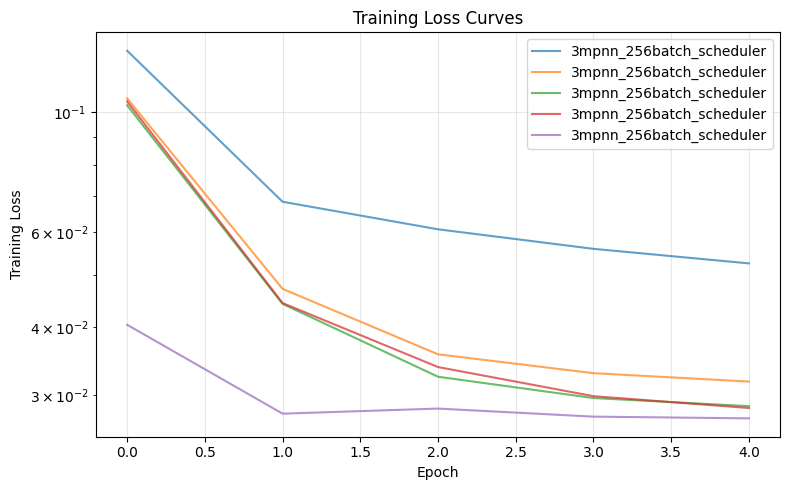

In [37]:
plt.figure(figsize=(8, 5))

# --- Only plot successful runs ---
successful_results = [r for r in all_results if 'train_loss_history' in r]

# Add val loss history

for result in successful_results:
    plt.plot(
        result['train_loss_history'],
        label=result['config_name'],
        alpha=0.7
    )

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<h2 >Visualize Predictions


Config: 3mpnn_256batch_scheduler

Accuracy Bands:
  < 0.05m: 3.4%
  < 0.1m: 15.3%
  < 0.5m: 99.3%
  < 1.0m: 100.0%


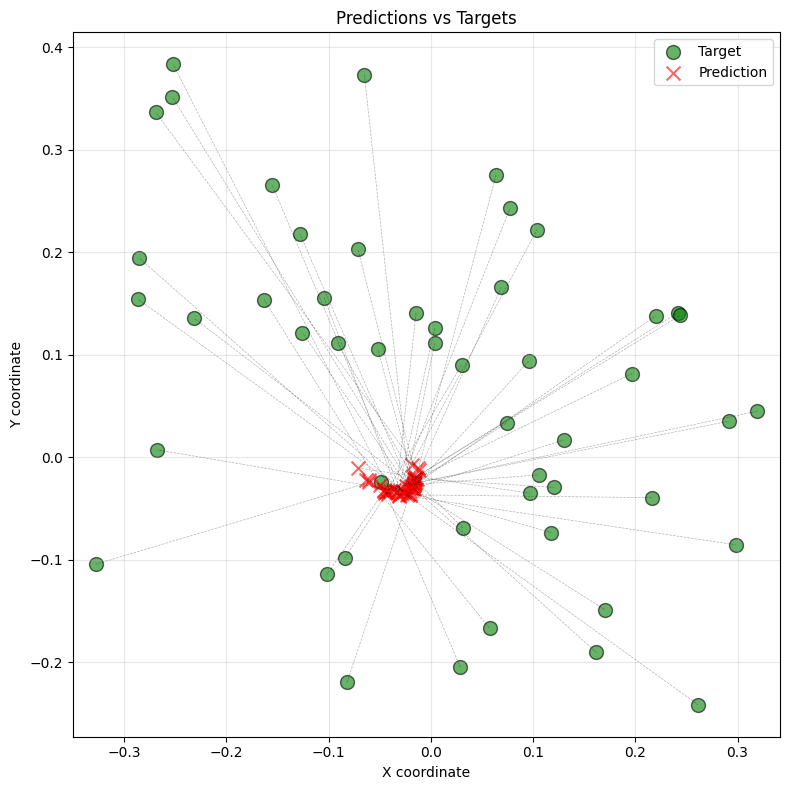

  Strength Mean Error: 0.1144

Config: 3mpnn_256batch_scheduler

Accuracy Bands:
  < 0.05m: 3.7%
  < 0.1m: 16.2%
  < 0.5m: 99.2%
  < 1.0m: 100.0%


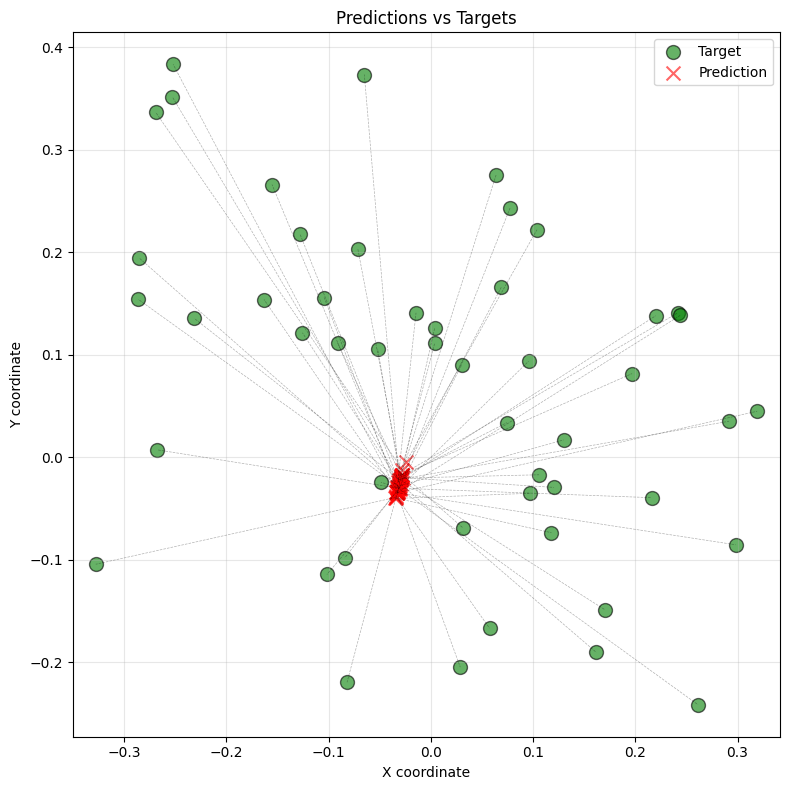

  Strength Mean Error: 0.1462

Config: 3mpnn_256batch_scheduler

Accuracy Bands:
  < 0.05m: 3.7%
  < 0.1m: 15.8%
  < 0.5m: 99.2%
  < 1.0m: 100.0%


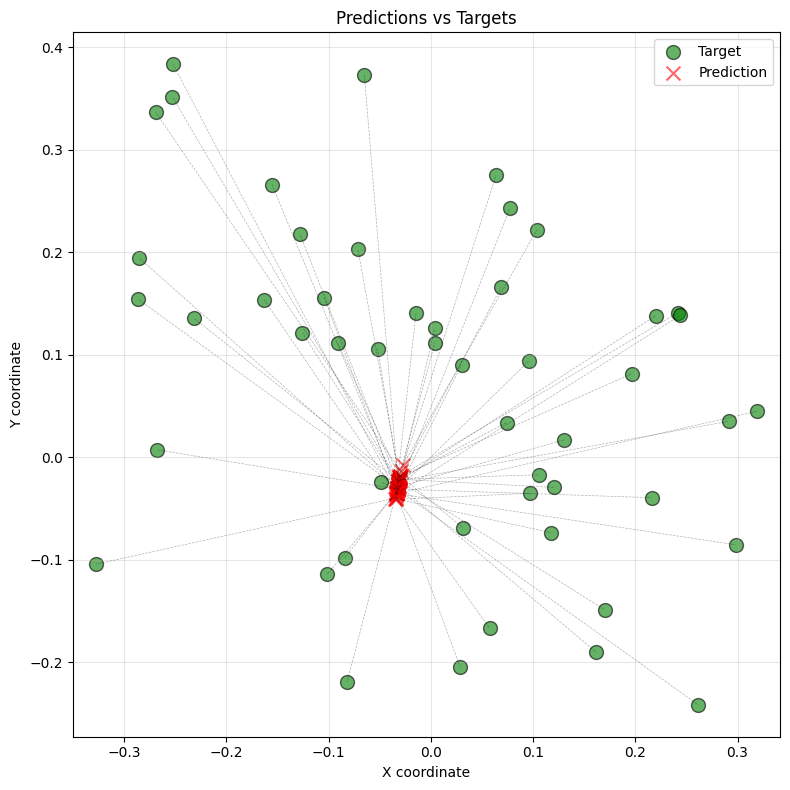

  Strength Mean Error: 0.1401

Config: 3mpnn_256batch_scheduler

Accuracy Bands:
  < 0.05m: 4.1%
  < 0.1m: 17.1%
  < 0.5m: 99.5%
  < 1.0m: 100.0%


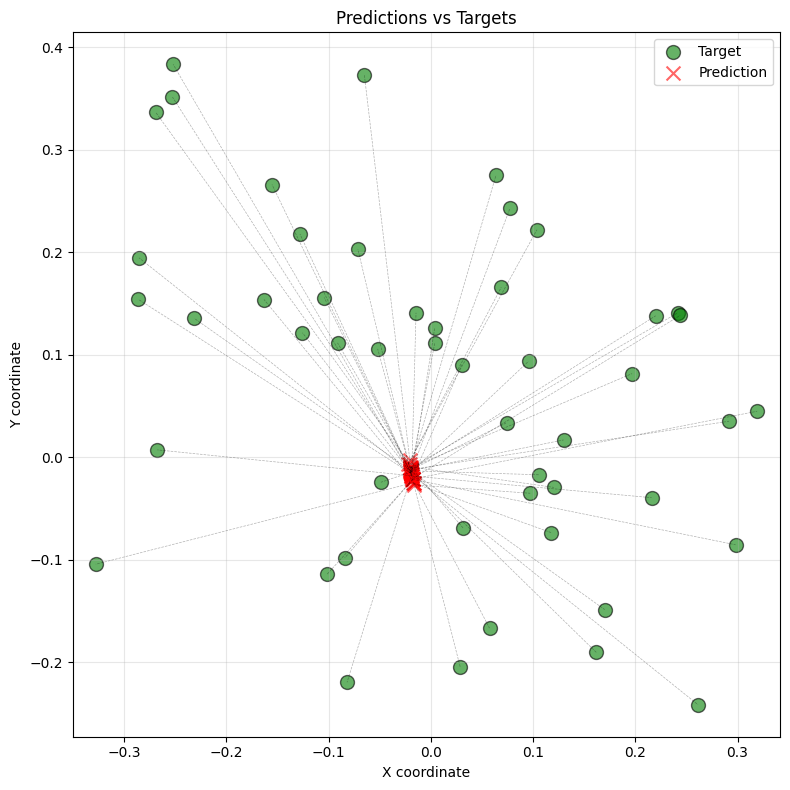

  Strength Mean Error: 0.1410

Config: 3mpnn_256batch_scheduler

Accuracy Bands:
  < 0.05m: 4.3%
  < 0.1m: 17.8%
  < 0.5m: 99.5%
  < 1.0m: 100.0%


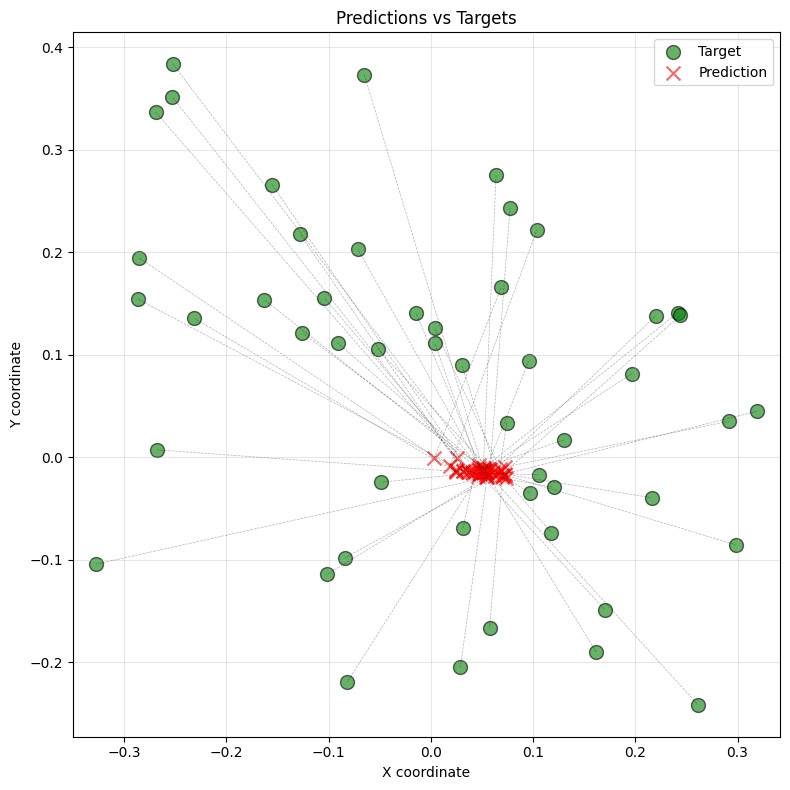

  Strength Mean Error: 0.1392


In [38]:
# Accuracy bands (assuming coordinates in meters)
successful_results = [r for r in all_results if 'train_loss_history' in r]

for r in successful_results:
    print(f"\nConfig: {r['config_name']}")
    loc = r.get('loc_predictions', None)
    targets = r.get('loc_targets', None)

    # --- Accuracy bands ---
    errors = np.linalg.norm(loc - targets, axis=1)
    acc_005m = (errors < 0.05).mean() * 100
    acc_01m = (errors < 0.1).mean() * 100
    acc_05m = (errors < 0.5).mean() * 100
    acc_10m = (errors < 1.0).mean() * 100

    print(f"\nAccuracy Bands:")
    print(f"  < 0.05m: {acc_005m:.1f}%")
    print(f"  < 0.1m: {acc_01m:.1f}%")
    print(f"  < 0.5m: {acc_05m:.1f}%")
    print(f"  < 1.0m: {acc_10m:.1f}%")

    # --- Plot 100 predictions vs targets ---
    visualize_predictions(loc, targets)

    # --- Strength predictions vs targets ---
    str_preds = r.get('str_predictions', None)
    str_tgts = r.get('str_targets', None)
    str_mae = np.abs(str_preds - str_tgts).mean()
    print(f"  Strength Mean Error: {str_mae:.4f}")
    
  

<h2> Save Results

In [61]:
import pickle

# --- Create results directory if it doesn't exist ---
results_dir = Path("/results")
#results_dir.mkdir(exist_ok=True)

# --- Generate filename with timestamp ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = results_dir / f"hyperparameter_search_{timestamp}.pkl"

# --- Save everything ---
with open(results_file, 'wb') as f:
    pickle.dump({
        'all_results': all_results,
        'configs': configs,
        'results_df': results_df,
        'metadata': {
            'seed': SEED,
            'device': str(device),
            'train_path': train_path,
            'val_path': val_path,
            'test_path': test_path,
        }
    }, f)

print(f"Results saved to: {results_file}")

# --- Also save CSV for spreadsheet analysis ---
csv_file = results_dir / f"hyperparameter_search_{timestamp}.csv"
results_df.to_csv(csv_file, index=False)
print(f"CSV saved to: {csv_file}")

FileNotFoundError: [Errno 2] No such file or directory: '/results/hyperparameter_search_20260213_180502.pkl'